# Criando Previsões de Preços para 5 dias Adiante

Dentro de uma empresa existem diversos fatores de risco para serem administrados, alguns destes são a variação de preços de produtos que podem impactar no fluxo de caixa, previsões de demanda de produtos, onde deve-se avaliar os melhores momentos de venda como também fazer a gestão de estoques, outro fator importante é de fazer previsões sobre gastos recorrentes, pois valores expressivos podem impactar capital de giro da empresa.

Usualmente, as estimativas de preços, demanda, gastos, etc. são criadas levando em consideração conhecimentos técnicos dos gestores, como também com informações essenciais sobre o assunto específico que influenciam a tomada de decisão. 
Quando modelos de previsão são usados, os dados são separados entre treino e teste, os coeficientes de multiplicação são gerados nos dados de treino e normalmente são testados passo a passo na base de testes, ou seja, somente um período é previsto, atualiza-se com dados reais e se prevê mais um dia e assim por diante até finalizar os dados de teste.

Neste notebook será criado um modelo [ARIMA](https://pt.wikipedia.org/wiki/ARIMA) e o teste dos coeficientes obtidos no treino será feito de uma maneira um pouco diferente, 5 dias consecutivos serão previstos, posteriormente atualizados com dados reais e novamente serão criadas novas previsões para 5 períodos adiante até os dados de teste acabarem. 

Este tipo de abordagem é interessante, pois para quem deseja criar modelos de previsão com vários períodos adiante pode-se comparar mais facilmente as extrapolações de previsões com os dados reais, assim, verifica-se mais facilmente quais são as principais características do modelo e quais são os pontos que podem ser melhorados.

O objetivo do modelo é prever o preço diário dos próximos 5 dias do Açúcar Cristal base São Paulo informado pela Esalq, os dados podem ser baixados **[aqui](https://www.cepea.esalq.usp.br/br/indicador/acucar.aspx).**

A partir de agora iremos usar os seguintes passos, extraidos deste meu post **[Princípios Básicos para Criar Previsões de Séries Temporais](https://medium.com/@leandrorabelo_65568/princ%C3%ADpios-b%C3%A1sicos-para-criar-previs%C3%B5es-de-s%C3%A9ries-temporais-e58c451a25b)**, caso você não tenha muita noção sobre as bases para se criar essas previsões, recomendo a leitura:

 * Dividir série em treino e teste
 * Transformar a série em estacionária
 * Procurar lags correlacionados
 * Criar o modelo
 * Plotar o gráfico comparativo na base de treino
 * Avaliar o modelo e o erro na base de testes
 * Sugerir possíveis melhorias do modelo.

Antes de tudo vamos importar as bibliotecas essenciais para se trabalhar com séries temporais:

In [1]:
#importando bibliotecas essenciais
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from matplotlib.animation import FuncAnimation
from math import sqrt
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib notebook
sns.set_context("paper")
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_excel('EsalqCristal.xls')
df['Data'] = pd.to_datetime(df['Data'], dayfirst=True)
df.sort_values('Data', inplace=True)
df.set_index('Data', inplace=True)
df.head()

,Cristal
Data,
2003-05-20,29.65
2003-05-21,29.26
2003-05-22,28.81
2003-05-23,28.35
2003-05-26,27.83


# Criando base de treino e teste

Temos um histórico de preços de aproximadamente 16 anos, vamos reservar os últimos **250 dias úteis** ( aprox. 1 ano) para testar o modelo, serão 50 comparativos de 5 dias cada, entre os valores previstos e reais. Todos os dados anteriores serão usados para treinar o modelo:

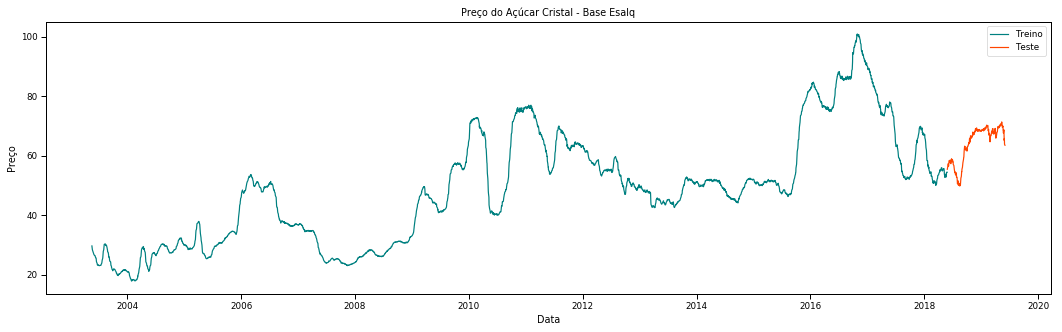

In [3]:
dias = 250
treino = df.iloc[:-dias,0:1].copy()
teste = df.iloc[-dias:,0:1].copy()
plt.figure(figsize=(18,5))
plt.title('Preço do Açúcar Cristal - Base Esalq')
plt.plot(treino['Cristal'], color='teal')
plt.plot(teste['Cristal'], color='orangered')
plt.legend(['Treino','Teste'])
plt.xlabel('Data')
plt.ylabel('Preço')
plt.show()

# Teste de estacionariedade e verificando Correlações

Para se criar uma previsão de série temporal é necessário que ela seja estacionária, ou seja, que ela tenha as seguintes condições relativamente constantes: média, variância e autocorrelação.

Abaixo irei usar a função abaixo para plotar a série, sua distribuição, [autocorrelação](https://pt.wikipedia.org/wiki/Autocorrela%C3%A7%C3%A3o) e autocorrelação parcial além de checar a estacionariedade usando o teste de [Dickey Fuller](https://en.wikipedia.org/wiki/Dickey%E2%80%93Fuller_test):

In [4]:
#criando uma função para plotar o gráfico e mostrar o resultado do teste:
def checar_estacionariedade(y, lags_plots=48, figsize=(22,8)):
    "Use Series como parâmetro"
    
    # Criando plots do DF
    y = pd.Series(y)
    fig = plt.figure()

    ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=2)
    ax2 = plt.subplot2grid((3, 3), (1, 0))
    ax3 = plt.subplot2grid((3, 3), (1, 1))
    ax4 = plt.subplot2grid((3, 3), (2, 0), colspan=2)

    y.plot(ax=ax1, figsize=figsize, color='teal')
    ax1.set_title('Série de Preços')
    plot_acf(y, lags=lags_plots, zero=False, ax=ax2, color='teal');
    plot_pacf(y, lags=lags_plots, zero=False, ax=ax3, method='ols', color='teal');
    sns.distplot(y, bins=int(sqrt(len(y))), ax=ax4, color='teal')
    ax4.set_title('Distribuição dos Preços')

    plt.tight_layout()
    
    print('Resultados do teste de Dickey-Fuller:')
    adfinput = adfuller(y)
    adftest = pd.Series(adfinput[0:4], index=['Teste Statistico','Valor-P','Lags Usados','Números de Observações'])
    adftest = round(adftest,4)
    
    for key, value in adfinput[4].items():
        adftest["Valores Críticos (%s)"%key] = value.round(4)
        
    print(adftest)

Para verificar se a série de treino é estacionária, iremos usar o valor P de 5% como base para estacionariedade, caso o valor P do teste seja inferior a 5% podemos considerar que a série é estacionária:

Resultados do teste de Dickey-Fuller:
Teste Statistico            -2.6288
Valor-P                      0.0872
Lags Usados                  7.0000
Números de Observações    3714.0000
Valores Críticos (1%)       -3.4321
Valores Críticos (5%)       -2.8623
Valores Críticos (10%)      -2.5672
dtype: float64


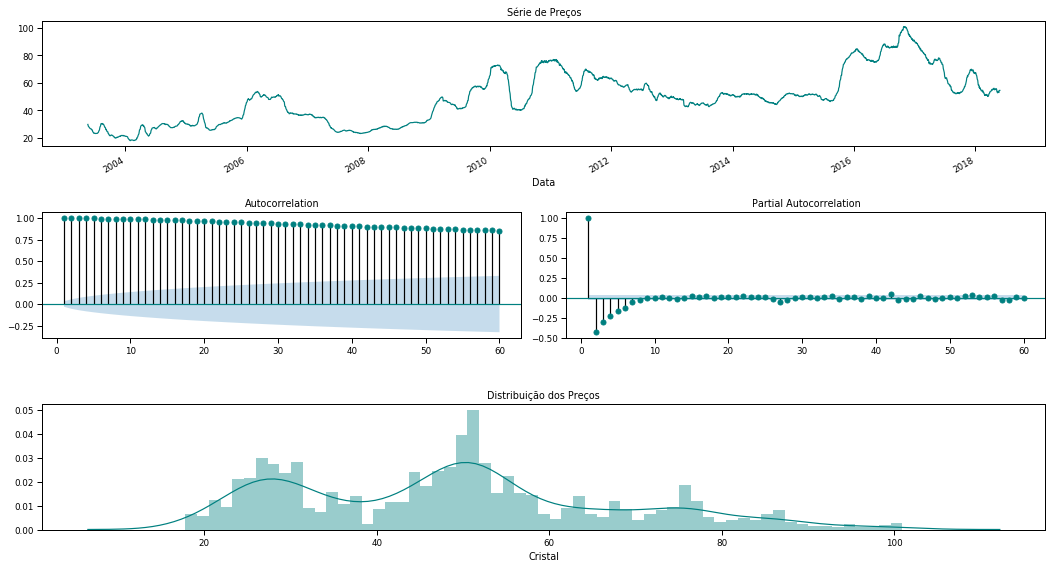

In [5]:
checar_estacionariedade(treino['Cristal'], lags_plots=60)

Analisando o gráfico da série de preços, nota-se que ele tem uma leve tendência de alta, observando os dados estatísticos a série ficou com o valor P de 8,7%, a distribuição dos dados não segue uma normalidade gaussiana, e as características da **autocorrelação** mostram correlações significativas em todos os lags, isso é sinal de uma série com tendência e que pode-se fazer ao menos uma diferenciação.

Assim, essa série não satisfaz os critérios estabelecidos para ser considerada estacionária.

Vou fazer a primeira diferenciação para retirar a tendência e ficar somente as movimentações dia-a-dia:

Resultados do teste de Dickey-Fuller:
Teste Statistico           -11.3823
Valor-P                      0.0000
Lags Usados                  5.0000
Números de Observações    3715.0000
Valores Críticos (1%)       -3.4321
Valores Críticos (5%)       -2.8623
Valores Críticos (10%)      -2.5672
dtype: float64


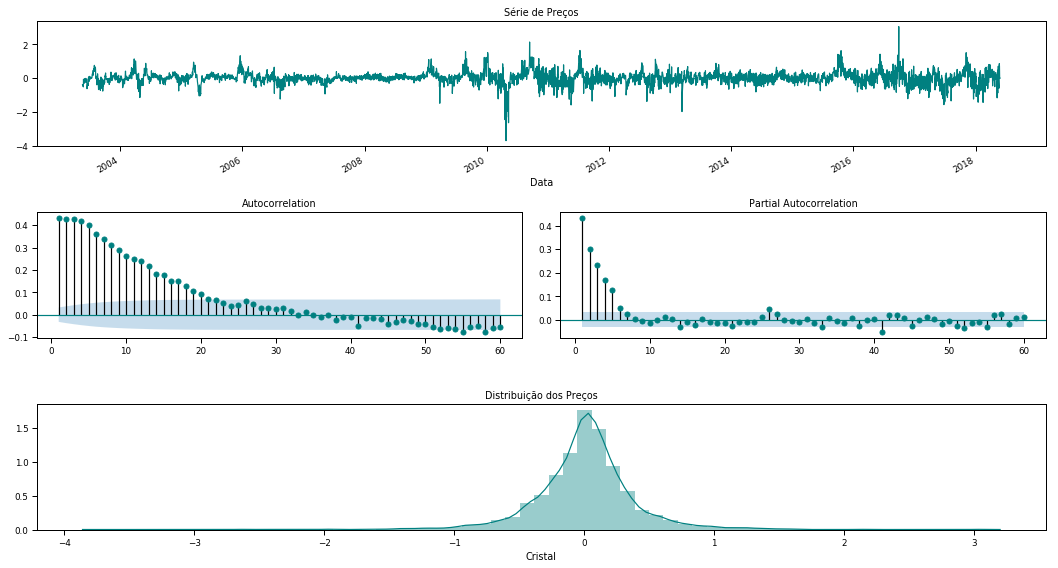

In [6]:
checar_estacionariedade(treino['Cristal'].diff().dropna(), lags_plots=60)

O teste de Dickey Fuller retornou o **valor P** de zero, isso significa que a série tornou-se estacionária, para complementar, nota-se no gráfico que a tendência desapareceu e os preços estão relativamente estáveis.

No gráfico de auto correlação os valores vão decrescendo gradualmente, diferente do gráfico sem diferenciação.

A auto correlação parcial cai mais abruptamente, demonstrando que os valores que realmente impactam sobre os valores atuais são principalmente os 3 primeiros lags, aparentemente não há correlação sazonal significativa para ser considerada nas previsões.

Dessa maneira, podemos considerar os 3 primeiros lags para um [modelo ARIMA](https://pt.wikipedia.org/wiki/ARIMA) com uma diferenciação, assim sendo usaremos a seguinte terminologia para o modelo: **ARIMA(3,1,0)**

# Criando o Modelo

Inicialmente o modelo será criado com base nos dados de treino, assim, os coeficientes para os 3 lags auto correlacionados serão gerados e servirão para testar a extrapolação de 5 dias consecutivos na base de testes.

Existem diversas maneiras de se fazer extrapolações para o futuro, as principais são:

 * Criar um modelo para cada dia a ser previsto e agregar tudo posteriormente,
 * Recursivo, prevendo o primeiro dia e usar essa previsão como base para prever o próximo dia.
 
Usaremos o último modelo neste exemplo, neste caso iremos prever os próximos 5 dias, comparar com dados reais, adicionar estes últimos novamente na base para fazer uma nova extrapolação, posteriormente iremos calcular o erro do modelo e analisar fatos relevantes da previsão.

In [7]:
# Treinando o modelo
modelo = ARIMA(treino, order=(3,1,0)).fit()
pred_treino = modelo.predict()

Vamos agora comparar os dados reais com os previstos, como a previsão foi feita sobre o modelo com diferenciação (como pode ser visto abaixo) o primeiro valor real será adicionado e somado cumulativamente para ter de volta a base de preço em R$/m3.

In [8]:
# Base de previsão com diferenciação
pred_treino[:5]

Data
2003-05-21    0.006286
2003-05-22   -0.164735
2003-05-23   -0.250335
2003-05-26   -0.298730
2003-05-27   -0.328869
dtype: float64

In [9]:
# Voltando para a base de preços em R$/m3
pred_treino[0] += treino.iloc[0,0]
pred_treino = np.cumsum(pred_treino)
pred_treino.head()

Data
2003-05-21    29.656286
2003-05-22    29.491551
2003-05-23    29.241216
2003-05-26    28.942486
2003-05-27    28.613616
dtype: float64

Agora os valores previstos serão adicionados na variável de treino para plotarmos o gráfico com as duas séries:

In [10]:
treino['Pred Cristal'] = pred_treino
treino.dropna(inplace=True)
treino.head()

,Cristal,Pred Cristal
Data,,
2003-05-21,29.26,29.656286
2003-05-22,28.81,29.491551
2003-05-23,28.35,29.241216
2003-05-26,27.83,28.942486
2003-05-27,27.76,28.613616


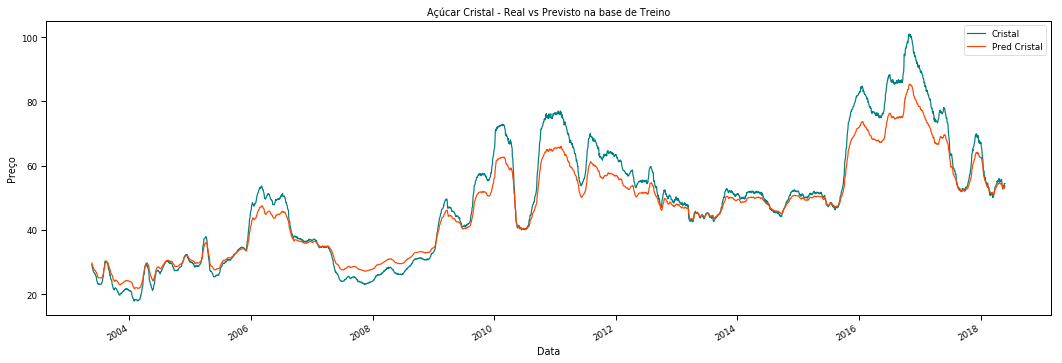

In [11]:
# Plotando o gráfico
treino.plot(figsize=(18,6), 
            title='Açúcar Cristal - Real vs Previsto na base de Treino',
           color=['Teal','orangered'])
plt.ylabel('Preço')
plt.show()

Na base de treino o modelo consegue capturar os principais momentos do mercado. Somente quando há maiores variações que a previsão não consegue capturar o movimento, agora vamos analisar o erro do modelo:

In [12]:
#Medindo o erro do treino pela métrica Root Mean Squared Error
from sklearn.metrics import mean_squared_error
erro = sqrt(mean_squared_error(treino['Cristal'], treino['Pred Cristal']))
print(f'O RMSE foi de R$ {round(erro,4)}/sc')

O RMSE foi de R$ 4.9671/sc


# Obtendo os Coeficientes

Após treinar o modelo, podemos obter os coeficientes de multiplicação dos lags junto com o valor da constante, esses valores servirão como base para extrapolarmos as previsões para os próximos 5 dias.

In [13]:
# Pegando os coeficientes de múltiplicação dos lags para usar na base de testes:
const, l1, l2, l3 = modelo.params

print(f'Valor da constante {round(const,4)}')
print(f'Coeficientes do Lag 1: {round(l1,4)}, Lag 2: {round(l2,4)} e Lag 3: {round(l3,4)}')

Valor da constante 0.0063
Coeficientes do Lag 1: 0.2332, Lag 2: 0.2297 e Lag 3: 0.2309


O próximo passo é criar uma função para fazer as previsões, usarei todas as bases com diferenciação, criarei a previsão para 5 períodos adiante e atualizarei os dados reais com mais 5 dias e assim sucessivamente até finalizarem os dados de teste.

In [14]:
def prever_n_per(treino, teste, passos):
    
    # Adicionando a série com diferenciação para projetar previsões
    diff_treino = treino.diff().dropna().values
    hist = [x for x in diff_treino]

    diff_teste = teste.diff().dropna().values
    diff_teste = [x for x in diff_teste]

    # Adicionando primeira diferenciação no teste que ficou entre o treino e teste
    prim_diff = treino[-1] - teste[0]
    diff_teste.insert(0, prim_diff)
    
    prev = []

    for i in range(0,len(teste),passos):
        for j in range(passos):
    
            yhat = const + (l1 * hist[-1]) + (l2 * hist[-2]) + (l3 * hist[-3])
            prev.append(yhat)
            # usando a previsão atual como base para novas previsões
            hist.append(yhat)
        obs = diff_teste[i:i+passos]
        hist = list(np.append(hist,obs))
    return prev

In [15]:
# Testando a função
steps = 5
prev = prever_n_per(treino['Cristal'], teste['Cristal'], passos=steps)
print('Previsões antes de reverter os preços: ')
print(prev[:5])

Previsões antes de reverter os preços: 
[0.17477782558127006, 0.053966184856814814, 0.059013042826703804, 0.07279059649919215, 0.04927191191727104]


Do mesmo jeito que criamos a função para prever os preços com 5 dias de extrapolação, iremos criar a função abaixo para transformar os preços previstos para a base comparável com os preços reais da base de teste.

In [16]:
def inverter_diff(treino, teste, previsão, passos):
    '''
    Usando o último dia da base de treino, após isso, usa o último valor previsto como base sucessivamente.
    
    A cada passo, volta a usar o primeiro valor da base de teste que se tornou real.
    '''
    treino = [x for x in treino]
    teste = [x for x in teste]
    prev_inv = []
    
    for i in range(0,len(teste), passos): 
        inverter = treino[-1] + previsão[i]
        prev_inv.append(inverter)
        
        for j in range(passos-1):
            inverter += previsão[i+j+1]
            prev_inv.append(inverter)
        treino = np.append(treino, teste[i:i+passos])
    return prev_inv

In [17]:
# Adicionando a previsão na base de testes para comparar posteriormente
teste['Previsão 5D'] = inverter_diff(treino['Cristal'],
                                    teste['Cristal'],
                                    prev, passos=steps)

# Plotando o Comparativo

Para finalizar, a função abaixo irá separar cada previsão pelos períodos de 5 dias e comparar com a base de testes:

In [18]:
def plotar_comparativo(orig, prev, passos, titulo='', figsize=(18,8)):
    plt.figure(figsize=figsize)
    
    orig = np.array(orig)
    prev = np.array(prev)
    plt.plot(orig, label='Real', color='teal')
    
    for i in range(0,len(orig), passos):
        eixo_x = [x for x in range(i,i+passos)]
        plt.plot(eixo_x, prev[i:i+passos], color='orangered')
    
    plt.title(titulo)
    plt.ylabel('Preços')
    plt.show()

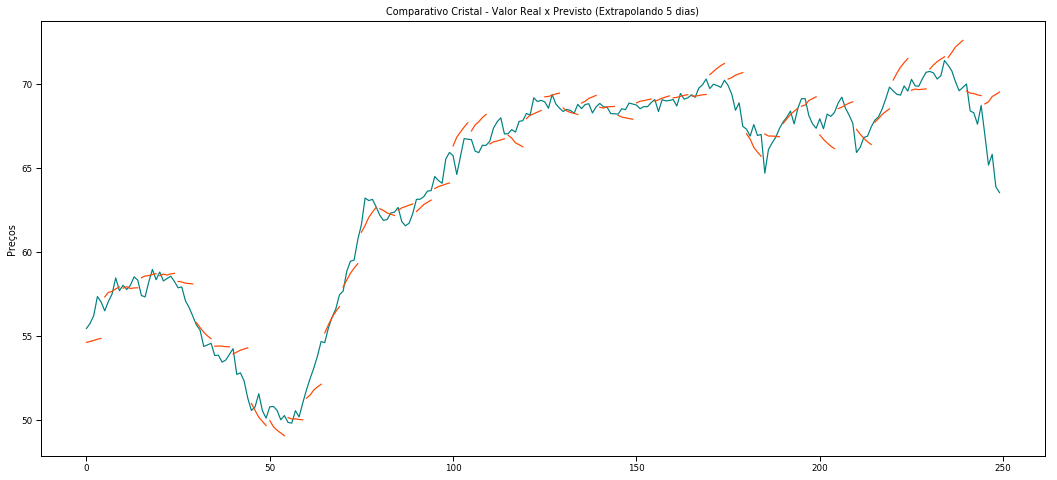

In [19]:
plotar_comparativo(teste['Cristal'], teste['Previsão 5D'], passos=steps, 
                   titulo='Comparativo Cristal - Valor Real x Previsto (Extrapolando 5 dias)')

In [20]:
erro_teste = sqrt(mean_squared_error(teste['Cristal'], teste['Previsão 5D']))
print(f'O RMSE da base de testes foi de R$ {round(erro_teste,4)}/sc')

O RMSE da base de testes foi de R$ 1.1522/sc


Avaliando o gráfico acima, nota-se que a principal característica desse tipo de previsão é que ele segue a tendência mais recente que está sendo negociada, porém ainda há espaço para melhoras, o modelo não é capaz de prever possíveis mudanças de tendências.

No próximo vai ser analisar o erro (previsto - real), pois neste tipo de análise pode-se obter informações para melhorar o modelo.

# Analisando o Erro

Para analisar o erro criarei uma função semelhante às anteriores, irão ser analisados os valores médios de cada um dos 5 passos, normalmente a tendência é que o erro, neste caso o RMSE, aumente de acordo com os períodos que vão se expandindo devido às incertezas, veremos abaixo:

In [21]:
def erro_n_passos(orig, prev, passos, plot=True):
    # Calculando o RMSE de cada linha
    erro = ((np.array(orig) - np.array(prev))**2)**(1/2)
    
    # Mudando o formato para ficar: (erros/exemplos, passos)
    erro = erro.reshape(int(len(erro)/passos), passos)
    
    # Fazendo a média do erro para cada passo
    media = erro.mean(axis=0)
    
    # Plotando o gráfico de erro
    if plot:
        indice = np.arange(0,passos)
        plt.figure(figsize=(12,4))
        plt.plot(media, 'o-', color='teal', markersize=8)
        plt.title('Erro Médio para Cada Passo', fontsize=15)
        plt.xlabel('Passos', fontsize=15)
        plt.ylabel('Erro', fontsize=15)
        for x,y in zip(indice, media):
            label = "{:.4f}".format(y)
            plt.annotate(label, (x, y), xytext=(x-0.1, y+.075), fontsize=12)
        plt.xticks(np.arange(passos), [x for x in range(1,passos+1)])
        plt.yticks([x for x in np.linspace(min(media)-0.2, max(media)+0.2, 10)])
        plt.grid(axis='y')
        plt.show()
    print(f'O RMSE para cada passo ficou assim: \n{media}')

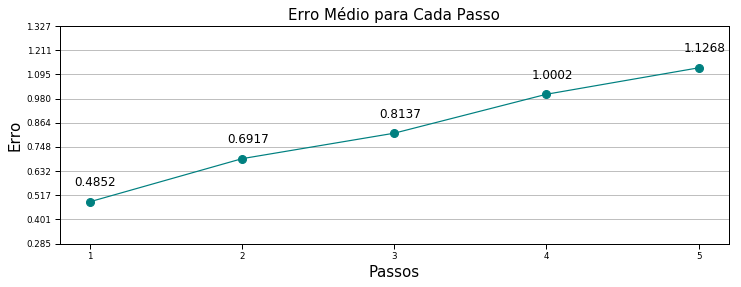

O RMSE para cada passo ficou assim: 
[0.48524694 0.69167403 0.81373203 1.00020175 1.12683736]


In [22]:
erro_passo = erro_n_passos(teste['Cristal'], teste['Previsão 5D'], steps)
erro_passo

Como previsto, a cada passo, a tendência é que o erro aumente, isso é devido ao aumento das incertezas quanto ao futuro e também que as previsões a partir do segundo passo são feitas sobre valores previstos e não reais.

Abaixo algumas ideias podem ajudar a melhorar a acurácia do modelo:

 * Pode-se criar um ensemble de vários modelos (LSTM, Garch, MLP, TBATS, etc) e fazer uma média dos preços,
 * Alguns modelos podem ter previsões melhores para algum período específico, pode-se usar a cada período o modelo que tiver o menor erro, podendo assim, ter um modelo final com bases de modelos diferentes e com erros menores,
 * Analisar métricas de erro diferentes tipo MAE, Bias, etc para verificar características Específicas de cada tipo de métrica,
 * Testar possíveis lags sazonais para prever movimentos recorrentes,
 * Adicionar dados externos correlacionados,
 * Normalizar os dados,
 * Fazer a transformação com logaritmos ou usando a transformação Box-Cox.
 
Modelos simples ou até com técnicas de Inteligência Artificial para criar previsões com vários períodos adiante são sem dúvidas uma ferramenta de extrema importância.

Diante de um mercado cada vez mais competitivo, criar um modelo com acurácia testada pode ser um diferencial para a empresa, pois ela poderá captar possíveis movimentos de mercado que podem ser essenciais na tomada de decisão do administrador.

Modelos semelhantes a este podem ser usados como ferramentas auxiliares para se criar fluxos de caixa, administrar produção e estoques, como também identificar oportunidades de mercado.

Espero que tenha gostado, qualquer dúvida ou informação, estou à disposição para responder eventuais questionamentos, segue também o link do meu [LinkedIn](https://www.linkedin.com/in/leandro-rabelo-08722824/) para contato.

# Adicional:

Abaixo criei uma animação, mostrando a dinâmica das previsões com as atualizações dos preços reais posteriormente:

<IPython.core.display.Javascript object>


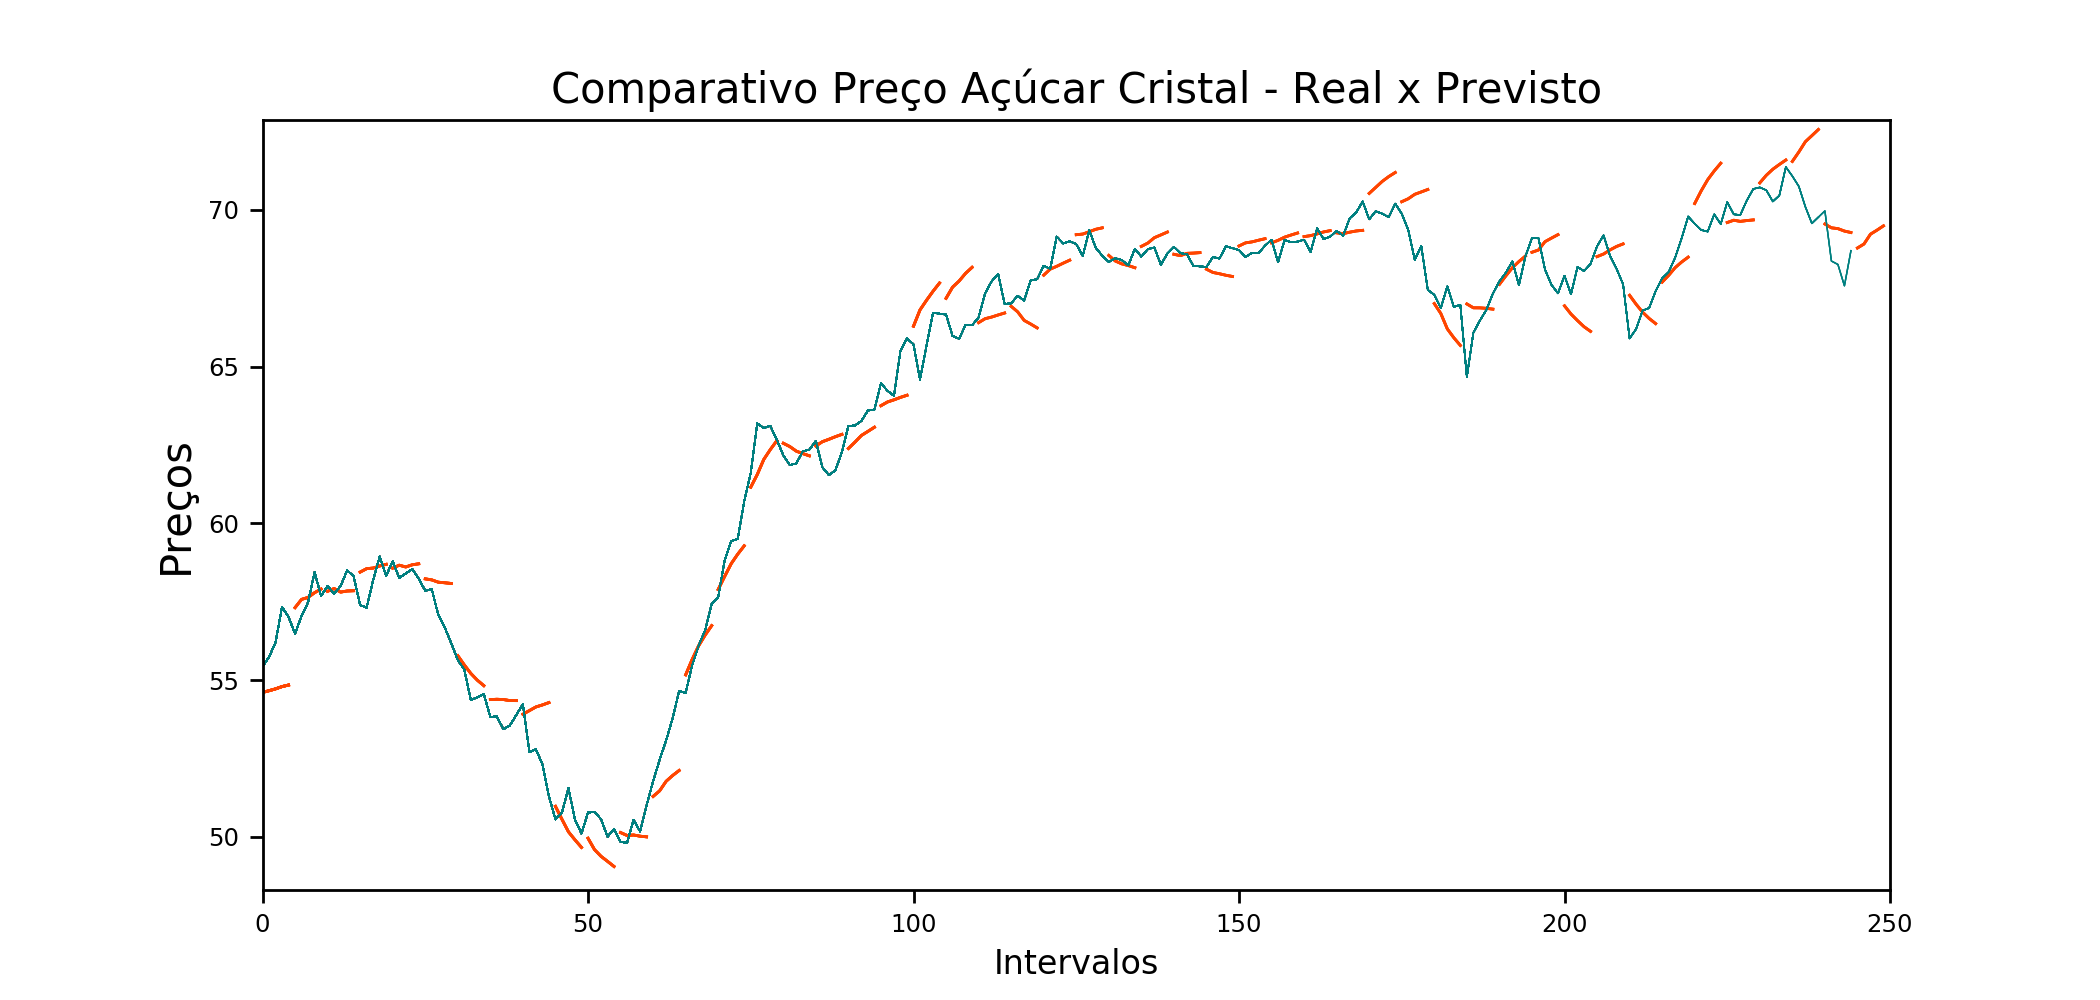

In [47]:
%matplotlib notebook

passos = 5
eixo_x_prev = []
eixo_x_real = [x for x in range(len(teste))]
prev = []
pred = np.array([x for x in teste['Previsão 5D']])
base = [x for x in teste['Cristal']]

for i in range(0,len(teste), passos):
    eixo_x_prev.append([x for x in range(i,i+passos)])
    prev.append([x for x in pred[i:i+passos]])

# Criando a base dos gráficos
fig = plt.figure(figsize=(10.5,5))
plt.axis([0, len(base), min(base)-2.5,max(base)+2.5])

def animate(i):
    
    plt.plot(eixo_x_prev[i], prev[i], c='orangered', lw=1)
    plt.plot(eixo_x_real[:i*passos], base[:i*passos], c='teal', lw=0.50)
plt.xlabel('Intervalos', fontsize=12)
plt.ylabel('Preços', fontsize=15)
plt.title('Comparativo Preço Açúcar Cristal - Real x Previsto', fontsize=15)
plt.axis([0, len(base), min(base)-1.5 ,max(base)+1.5])
    

ani = FuncAnimation(fig, animate, frames=50, interval=250)
#ani.save('comparativo.htm')
plt.show()

Fontes:

[Multi-step Time Series Forecasting with Machine Learning for Electricity Usage](https://machinelearningmastery.com/multi-step-time-series-forecasting-with-machine-learning-models-for-household-electricity-consumption/)

[4 Strategies for Multi-Step Time Series Forecasting](https://machinelearningmastery.com/multi-step-time-series-forecasting/).